# Detecção de Retas e Círculos com a Transformada de Hough

A **Transformada de Hough** é uma metodologia capaz de fazer a detecção de objetos baseados em figuras geométricas ou em uma nuvem de pontos. O OpenCV implementa a Transformada de Hough para a detecção de lihas retas e círculos. 

In [1]:
import cv2
import auxiliar as aux
import hough_helper
from matplotlib import pyplot as plt
import numpy as np

# Detecção de retas Usando a Transformada de Hough

Para detectar as retas, a transformada de Hough levanta todas as possíveis retas que passam por um determinado ponto de borda, representadas por seus parâmetros $\rho$ e $\theta$. Os parâmetros dessas retas recebem um voto em uma *matriz de votação*, ou *acumulador*. Quanto mais pontos uma determinada reta pode cruzar, mais votos seus parãmetros receberão.

## Encontrar os Pontos de Borda

Para encontrar os pontos de borda, podemos usar o método de Canny, por exemplo.

Lembrando que para usar o método de Canny, precisamos de uma imagem em escala de cinza.

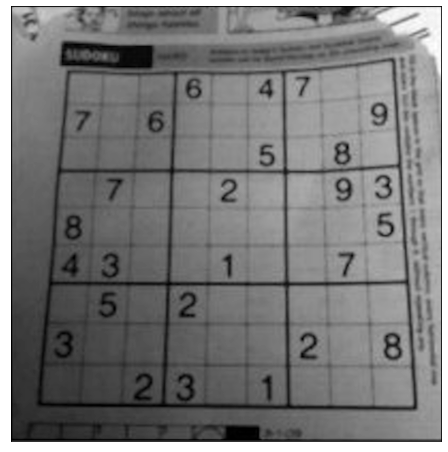

In [2]:
img = cv2.imread('img/dave.jpg',cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img)

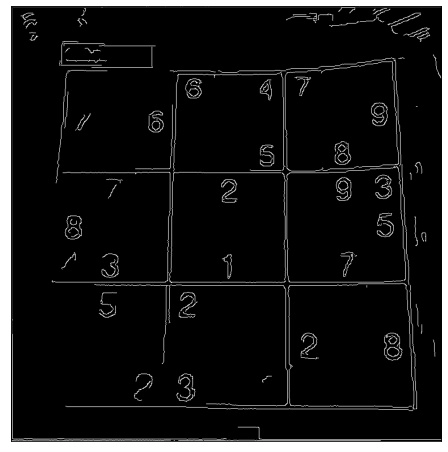

In [3]:
bordas = hough_helper.auto_canny(img)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(bordas)

## Uso da função HoughLines


O uso básico da função para a detecção de retas com a Transformada de Hough é:

    lines = cv2.HoughLines( image, rho, theta, threshold )
    

- `image`: Imagem de 8 bits contendo os pontos de borda na cor branca
- `lines`: Matriz de saída das linhas detectadas. Cada linha da matriz contém 2 elementos (ρ,θ):
    + `ρ` é a distancia da reta à origem das coordenadas (0,0)
    + `θ` é o ângulo da reta
- `rho`: Resolução da distância em pixels. 1 pixel está OK.
- `theta`: Resolução do ângulo em radiandos. 1 rad está OK.
- `threshold`: Limiar de detecção da reta. São retornadas apenas aquelas retas com número suficiente de votos (>`threshold`).

A partir da imagem acima, vamos detectar as retas usando a Transformada de Hough e depois desenhá-las na imagem original.

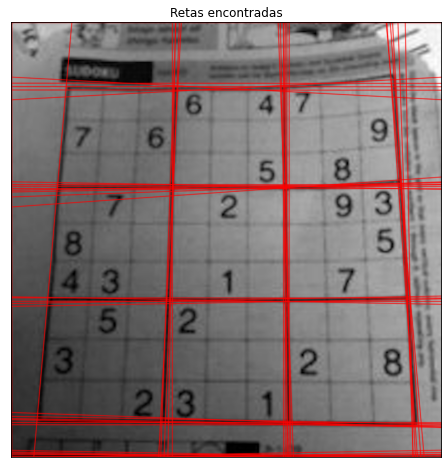

In [4]:
lines = cv2.HoughLines(bordas, 1, np.pi/180, 100)
img_retas = hough_helper.desenha_retas(img.copy(), lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas, "Retas encontradas")


Podemos aplicar a técnica de *Non-Maximum Suppression*, ou seja, se encontrarmos uma boa reta $(\rho, \theta)$, descartamos as próximas que tenham parâmetros parecidos 

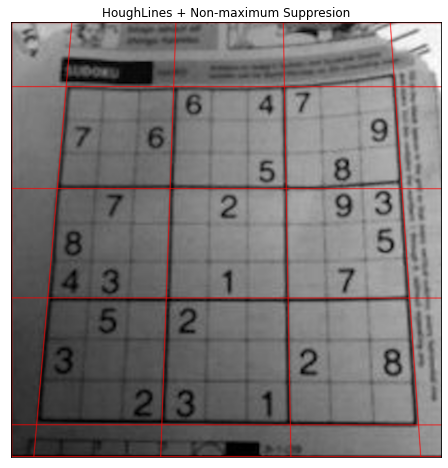

In [5]:
lines = cv2.HoughLines(bordas, 1, np.pi/180, 100)
suppressed_lines = hough_helper.non_max_suppression(lines, 40, np.radians(20))
img_retas_ = hough_helper.desenha_retas(img.copy(), suppressed_lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas_, "HoughLines + Non-maximum Suppresion")

E se quisermos encontrar apenas as retas horizontais?

Observe a imagem abaixo: 

*Considere que o eixo x está na horizontal e o eixo y na vertical*

<p><img src="img/coeficientes_m.png" alt="coeficientes_m" width="50%"></p>

Lembrando que a função `HoughLines` retorna os parâmetros $(\rho, \theta)$ de cada reta detectada, podemos usar o parâmetro `theta` para filtrar as retas horizontais.


[[[1.0, 1.5707964]], [[1.0, 0.0]], [[487.0, 1.5707964]], [[767.0, 1.5707964]], [[294.0, 1.5707964]], [[711.0, 1.5707964]], [[-480.0, 3.1241393]], [[114.0, 1.5707964]], [[-667.0, 3.0717795]], [[291.0, 0.034906585]], [[107.0, 0.08726646]]]
[[[1.0, 1.5707964]], [[487.0, 1.5707964]], [[767.0, 1.5707964]], [[294.0, 1.5707964]], [[711.0, 1.5707964]], [[114.0, 1.5707964]]]


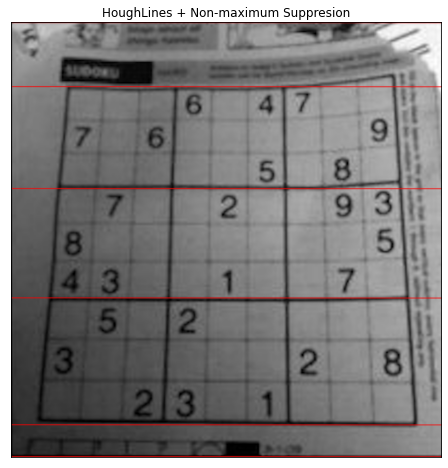

In [6]:
print(suppressed_lines)

horizontal_lines = []
for line in suppressed_lines:
    rho, theta = line[0]
        
    if 1.4 < theta < 1.6: 
        horizontal_lines.append([[rho, theta]])

print(horizontal_lines)
img_retas_ = hough_helper.desenha_retas(img.copy(), horizontal_lines)

plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_retas_, "HoughLines + Non-maximum Suppresion")


## A função HoughLinesP

É uma implementação eficiente da função HoughLines ([ver explicação](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)). Em vez de retornar os parâmetros da treta, retorna uma lista de segmentos de reta identificados pelos pontos `inicial` e `final`.


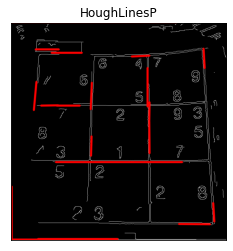

In [7]:
lines = cv2.HoughLinesP(bordas, 10, np.pi/180.0, threshold=60, minLineLength=60, maxLineGap=10)

a,b,c = lines.shape

hough_img_rgb = cv2.cvtColor(bordas, cv2.COLOR_GRAY2BGR)

for i in range(a):
    # Faz uma linha ligando o ponto inicial ao ponto final, com a cor vermelha (BGR)
    cv2.line(hough_img_rgb, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 5, cv2.LINE_AA)
    
hough_helper.mostra_imagem(hough_img_rgb, "HoughLinesP")

## Encontrando circunferências na imagem

A implementação da transformada de Hough para encontrar circunferências emprega algumas otimizações que tornam desnecessário encontrar as bordas da imagem antes. No entanto, se usarmos a imagem resultante da magnitude do gradiente, teremos um melhor resultado, pois as bordas estarão mais detacadas. Outras melhorias que podemos aplicar antes do realce das bordas são:

- Leve redução do contraste para equilibrar a iluminação na imagem
- Uso do filtro da mediana para atenuação de ruído

O uso básico da função para a detecção de circunferências com a Transformada de Hough é:
    
    circles = cv2.HoughCircles(image, method, dp, minDist, param1, param2, minRadius, maxRadius)

- `image`: Imagem de 8 bits onde as circunferências serão procuradas
- `method`: método usado para encontrar os possíveis centros de cada circunferência. Aqui vamos usar `cv2.HOUGH_GRADIENT`.
- `dp`: resolução usada na procura pelos centros das circunferências
- `minDist`: menor distância permitida entre os centros das circunferências encontradas
- `param1`: limiar empregado na detecção dos pontos de borda
- `param2`: limiar de detecção da circunferência
- `minRadius`: menor raio da circunferência a ser encontradas
- `maxRadius`: maior raio da circunferência a ser encontradas

Veja o exemplo do uso da função na imagem das bordas realçadas acima


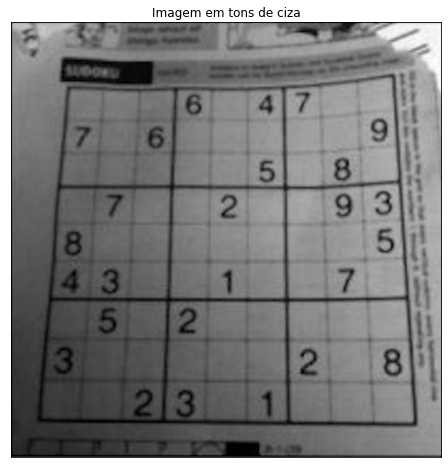

In [8]:
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img, "Imagem em tons de ciza")

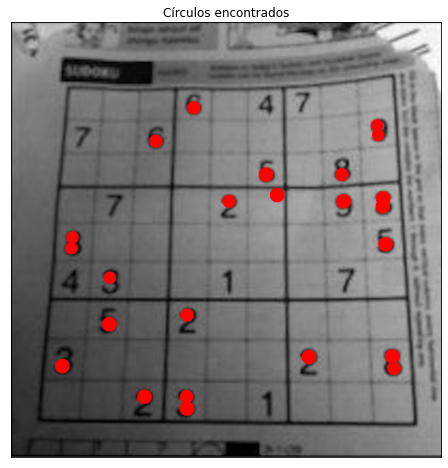

In [9]:
circles = cv2.HoughCircles(img, method=cv2.HOUGH_GRADIENT, dp=1, minDist=12, param1=40, param2=13, minRadius=10, maxRadius=14)

img_circles = hough_helper.desenha_circulos(img, circles)
plt.figure(figsize=(8,8))
hough_helper.mostra_imagem(img_circles, "Círculos encontrados")